In [111]:
from __future__ import division, print_function
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, sampler
from skimage import io



# Import data

In [112]:
# Common rule for tiny Imagenet:
#    label: int number used for model
#    ID (ex. n04371043) 
#    class_name: use for display (ex. bees, ants)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

TINY_IMAGENET = '/mnt/hdd1/thangvubk/workspace/\
ImageNetDataset/ImageNetTiny/tiny-imagenet-200/'


TINY_IMAGENET_TRAIN = TINY_IMAGENET + 'train'
TINY_IMAGENET_VAL = TINY_IMAGENET + 'val'
TINY_IMAGENET_TEST = TINY_IMAGENET + 'test'

train_dataset = datasets.ImageFolder(
    TINY_IMAGENET_TRAIN,
    data_transforms['train'])

# val_dataset = datasets.ImageFolder(
#     TINY_IMAGENET_VAL,
#     data_transforms['val'])

test_dataset = datasets.ImageFolder(
    TINY_IMAGENET_TEST,
    data_transforms['test'])

# just for show data
train_loader = DataLoader(train_dataset, batch_size=4,
                         shuffle=True, num_workers=4)

# Get class ID (equivalent to name of train sub folder)
class_ID = train_dataset.classes

# Create dataset class for validation set
Because validation set store label in a text file

In [113]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        return pil_loader(path)
class ValidationDataset(Dataset):
    """Validation dataset from annotation file."""

    def __init__(self, image_dir, annot_file, wnids_file, transform=None):

        with open(annot_file, 'r') as f:
            annots = f.readlines()
        # annots[0] = imagepath
        # annots[1] = image_ID
        # example val_10.JPEG <=> n04371043
        annots = [x.strip().split('\t') for x in annots]
        
        with open(wnids_file, 'r') as f:
            wnids = f.readlines()
        wnids = [x.strip() for x in wnids]
        wnids.sort()
        ID_to_label = {}
        for label, ID in enumerate(wnids):
            ID_to_label[ID] = label
        
        self.annots = annots
        self.image_dir = image_dir
        self.ID_to_label = ID_to_label
        self.transform = transform

    def __len__(self):
        return len(self.annots)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.annots[idx][0])
        with open(img_name, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')
        ID = self.annots[idx][1]
        label = self.ID_to_label[ID]
        if self.transform:
            image = self.transform(image)

        return image, label

val_dataset = ValidationDataset(
    image_dir=os.path.join(TINY_IMAGENET_VAL,'images'),
    annot_file=os.path.join(TINY_IMAGENET,'val/val_annotations.txt'),
    wnids_file=os.path.join(TINY_IMAGENET,'wnids.txt'),
    transform=data_transforms['val'])

# just for show data
val_loader = DataLoader(val_dataset, batch_size=4,
                         shuffle=True, num_workers=4)

# Create class name for class ID

In [114]:
# class_map: ID <=> Class name
CLASS_MAP = TINY_IMAGENET + 'words.txt'
with open(CLASS_MAP) as f:
    class_map = f.readlines()
class_map = [x.strip().split('\t') for x in class_map]

# print some example 
for i in range(5):
    print(class_map[i])

# feed to dict
ID_to_name = {}
for item in class_map:
    ID_to_name[item[0]] = item[1]
    

['n00001740', 'entity']
['n00001930', 'physical entity']
['n00002137', 'abstraction, abstract entity']
['n00002452', 'thing']
['n00002684', 'object, physical object']


# Show some examples

training example


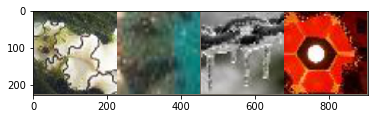

sea slug, nudibranch | sea cucumber, holothurian | chain | lampshade, lamp shade

validation example


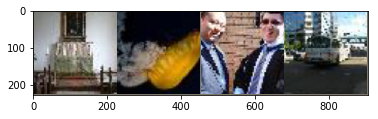

altar | jellyfish | academic gown, academic robe, judge's robe | trolleybus, trolley coach, trackless trolley


In [115]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)



print('training example')
imshow(out)
print(' | '.join('%s'%ID_to_name[class_ID[i]] for i in labels))

# Validation example
print()
print('validation example')
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out)
print(' | '.join('%s'%ID_to_name[class_ID[i]] for i in classes))
image, label = val_dataset[0]

In [109]:
use_gpu = torch.cuda.is_available()

def check_acc(model, dataset, batch_size=8):
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=4)
    
    running_corrects = 0
    for inputs, labels in dataloader:
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        running_corrects += torch.sum(preds == labels.data)
    return running_corrects/len(dataset)

def export(model, dataset):
    dataloader = DataLoader(dataset, 
                            batch_size=1,
                            shuffle=False,
                            num_workers=4)
    f = open('result.txt', 'w')
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        pred.squeeze()
        # test_2555.JPEG n07871810
        f.write('test_'+str(i)+'.JPEG '+class_ID[pred[0]]+'\n')
        
    f.close()

def visualize_model(model, dataset, batch_size=8,
                    num_images=6):
    images_so_far = 0
    fig = plt.figure()
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=4)
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(ID_to_name[class_ID[preds[j]]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return
        
        
def train_model(model, loss_fn, optimizer,
                num_epochs=25, batch_size=512):
    loss_hist = []
    since = time.time()
    
    best_model_state = model.state_dict()
    best_val = -1
    
    # use train loader with new batch size
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=4)
    
    for epoch in range(num_epochs):
        # set model in training mode
        model.train()
        running_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            if i%10 == 0:
                print('Epoch %d/%d Iter %d' %(
                    epoch, num_epochs-1, i))
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss_hist.append(loss.data[0])
            
            running_loss += loss.data[0]
            
            loss.backward()
            optimizer.step()
            #break
        
        epoch_loss = running_loss*batch_size/len(train_dataset)
        print('')
        print('Epoch finish')
        print('Training loss: %.4e' % epoch_loss)
        
        # validation
        # set model to eval mode
        model.eval()
        #train_acc = check_acc(model, train_dataset)
        val = check_acc(model, val_dataset)
        
        #print('Train acc: %.3f' %train_acc)
        print('Val acc: %.3f' %val)
        print('-'*10)
        
        if best_val < val:
            best_val = val
            best_model_state = model.state_dict()
    
    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time//60, elapsed_time%60))
    print('Best val acc: %3f' %best_val)
    
    model.load_state_dict(best_model_state)
    return loss_hist
    

# Finetuning the pretrained model

In [56]:
model_ft = models.alexnet(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 200)
    )

if use_gpu:
    model_ft = model_ft.cuda()

loss_fn = nn.CrossEntropyLoss()


In [71]:
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=5e-5)
loss_hist = train_model(model_ft, loss_fn, optimizer,
                       batch_size=512, num_epochs=2)

Epoch 0/1 Iter 0
Epoch 0/1 Iter 10
Epoch 0/1 Iter 20
Epoch 0/1 Iter 30
Epoch 0/1 Iter 40
Epoch 0/1 Iter 50
Epoch 0/1 Iter 60
Epoch 0/1 Iter 70
Epoch 0/1 Iter 80
Epoch 0/1 Iter 90
Epoch 0/1 Iter 100
Epoch 0/1 Iter 110
Epoch 0/1 Iter 120
Epoch 0/1 Iter 130
Epoch 0/1 Iter 140
Epoch 0/1 Iter 150
Epoch 0/1 Iter 160
Epoch 0/1 Iter 170
Epoch 0/1 Iter 180
Epoch 0/1 Iter 190

Epoch finish
Training loss: 2.8045e+00
Val acc: 0.487
----------
Epoch 1/1 Iter 0
Epoch 1/1 Iter 10
Epoch 1/1 Iter 20
Epoch 1/1 Iter 30
Epoch 1/1 Iter 40
Epoch 1/1 Iter 50
Epoch 1/1 Iter 60
Epoch 1/1 Iter 70
Epoch 1/1 Iter 80
Epoch 1/1 Iter 90
Epoch 1/1 Iter 100
Epoch 1/1 Iter 110
Epoch 1/1 Iter 120
Epoch 1/1 Iter 130
Epoch 1/1 Iter 140
Epoch 1/1 Iter 150
Epoch 1/1 Iter 160
Epoch 1/1 Iter 170
Epoch 1/1 Iter 180
Epoch 1/1 Iter 190

Epoch finish
Training loss: 2.7960e+00
Val acc: 0.489
----------
Training complete in 1m 56s
Best val acc: 0.489300


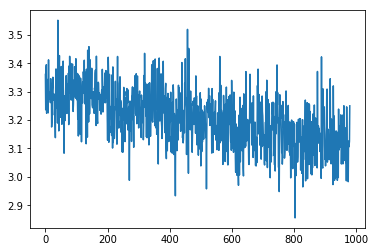

In [59]:
plt.plot(lost_hist)

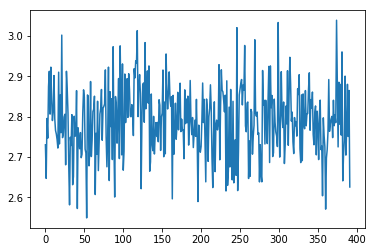

In [72]:
plt.plot(loss_hist)

# Non-pretrained model

In [47]:
model_nonft = models.alexnet(pretrained=False)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nonft.parameters(), lr=1e-4)

if use_gpu:
    model_nonft = model_nonft.cuda()

In [54]:
loss_hist = train_model(model_nonft, loss_fn, optimizer,
                       batch_size=512, num_epochs=5)

Epoch 0/4 Iter 0
Epoch 0/4 Iter 10
Epoch 0/4 Iter 20
Epoch 0/4 Iter 30
Epoch 0/4 Iter 40
Epoch 0/4 Iter 50
Epoch 0/4 Iter 60
Epoch 0/4 Iter 70
Epoch 0/4 Iter 80
Epoch 0/4 Iter 90
Epoch 0/4 Iter 100
Epoch 0/4 Iter 110
Epoch 0/4 Iter 120
Epoch 0/4 Iter 130
Epoch 0/4 Iter 140
Epoch 0/4 Iter 150
Epoch 0/4 Iter 160
Epoch 0/4 Iter 170
Epoch 0/4 Iter 180
Epoch 0/4 Iter 190

Epoch finish
Training loss: 3.3056e+00
Val acc: 0.323
----------
Epoch 1/4 Iter 0
Epoch 1/4 Iter 10
Epoch 1/4 Iter 20
Epoch 1/4 Iter 30
Epoch 1/4 Iter 40
Epoch 1/4 Iter 50
Epoch 1/4 Iter 60
Epoch 1/4 Iter 70
Epoch 1/4 Iter 80
Epoch 1/4 Iter 90
Epoch 1/4 Iter 100
Epoch 1/4 Iter 110
Epoch 1/4 Iter 120
Epoch 1/4 Iter 130
Epoch 1/4 Iter 140
Epoch 1/4 Iter 150
Epoch 1/4 Iter 160
Epoch 1/4 Iter 170
Epoch 1/4 Iter 180
Epoch 1/4 Iter 190

Epoch finish
Training loss: 3.2544e+00
Val acc: 0.336
----------
Epoch 2/4 Iter 0
Epoch 2/4 Iter 10
Epoch 2/4 Iter 20
Epoch 2/4 Iter 30
Epoch 2/4 Iter 40
Epoch 2/4 Iter 50
Epoch 2/4 Iter 60
Epoch

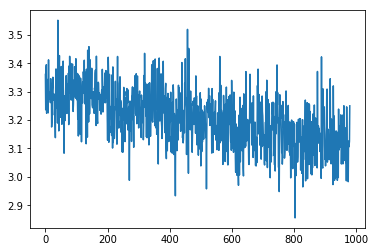

In [55]:
%matplotlib inline
plt.plot(lost_hist)

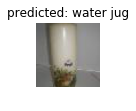

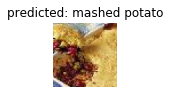

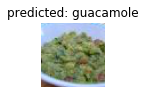

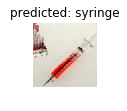

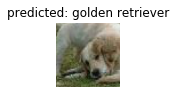

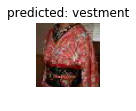

In [96]:
visualize_model(model_ft, test_dataset, num_images=6)

In [110]:
export(model_ft, test_dataset)